In [2]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import log_loss
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

import cfbd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

## 1. Load the Data

In [3]:
YEARS = range(2013, 2025)
DATA_DIR = '../data'

In [4]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower())
    return cols_new

In [5]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in YEARS:
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp = df_tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp = df_tmp.assign(
            home_division=df_tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=df_tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        df_tmp = df_tmp[id_cols + home_cols + away_cols]
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_games.head()

Reading ../data/games/2013.parquet from cached data
Reading ../data/games/2014.parquet from cached data
Reading ../data/games/2015.parquet from cached data
Reading ../data/games/2016.parquet from cached data
Reading ../data/games/2017.parquet from cached data
Reading ../data/games/2018.parquet from cached data
Reading ../data/games/2019.parquet from cached data
Reading ../data/games/2020.parquet from cached data
Reading ../data/games/2021.parquet from cached data
Reading ../data/games/2022.parquet from cached data
Reading ../data/games/2023.parquet from cached data
Reading ../data/games/2024.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,start_date,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo
0,332412309,2013,1,regular,True,False,3696.0,2013-08-29 22:00:00+00:00,2309,Kent State,Mid-American,fbs,17.0,1530.0,2335,Liberty,Big South,fcs,10.0,1467.0
1,332412579,2013,1,regular,True,False,3994.0,2013-08-29 22:00:00+00:00,2579,South Carolina,SEC,fbs,27.0,1759.0,153,North Carolina,ACC,fbs,10.0,1638.0
2,332410154,2013,1,regular,True,False,3630.0,2013-08-29 22:30:00+00:00,154,Wake Forest,ACC,fbs,31.0,NaN,2506,Presbyterian,Big South,fcs,7.0,NaN
3,332412710,2013,1,regular,True,False,3746.0,2013-08-29 23:00:00+00:00,2710,Western Illinois,MVFC,fcs,42.0,NaN,2261,Hampton,MEAC,fcs,9.0,NaN
4,332412050,2013,1,regular,True,False,3919.0,2013-08-29 23:00:00+00:00,2050,Ball State,Mid-American,fbs,51.0,NaN,2287,Illinois State,MVFC,fcs,28.0,NaN


In [6]:
# Load plays data
all_dfs = []
cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'offense',
       'offense_conference', 'offense_score', 'defense', 'home', 'away',
       'defense_conference', 'defense_score', 'period', 'offense_timeouts',
       'defense_timeouts', 'yardline', 'yards_to_goal', 'down', 'distance',
       'yards_gained', 'scoring', 'play_type', 'play_text', 'ppa',
       'clock_minutes', 'clock_seconds']

plays_dir = join(DATA_DIR, 'plays')
if not os.path.exists(plays_dir):
    os.makedirs(plays_dir)

for year in YEARS:
    season_file_path = join(plays_dir, f'{year}.parquet')
    
    if os.path.exists(season_file_path):
        print(f'Reading {season_file_path} from cached data')
        df_season_plays = pd.read_parquet(season_file_path)
    else:
        print(f'Fetching all weeks plays data for {year} from CFBD API')
        weeks = df_games.query('season == @year').week.unique().tolist()

        season_dfs = []
        for week in weeks:
            print(f'Fetching {year} plays data for week {week} from CFBD API')
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.PlaysApi(api_client)
                data = api_instance.get_plays(year=year, week=week)
            df_tmp = pd.DataFrame([val.to_dict() for val in data])
            if df_tmp.empty:
                print(f'No plays data for {year} week {week}')
                continue
            df_tmp.columns = convert_to_snake_case(df_tmp.columns)

            df_tmp['clock_minutes'] = df_tmp['clock'].apply(lambda x: x['minutes'])
            df_tmp['clock_seconds'] = df_tmp['clock'].apply(lambda x: x['seconds'])
            df_tmp.drop(columns=['clock'], inplace=True)

            df_tmp = df_tmp[cols]
            season_dfs.append(df_tmp)
        
        df_season_plays = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)
        
        df_season_plays.to_parquet(season_file_path)
        print(f'Saved plays data for {year} to {season_file_path}')
        del season_dfs, df_tmp

    all_dfs.append(df_season_plays)

    del df_season_plays
    
df_plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_plays.head()

Reading ../data/plays/2013.parquet from cached data
Reading ../data/plays/2014.parquet from cached data
Reading ../data/plays/2015.parquet from cached data
Reading ../data/plays/2016.parquet from cached data
Reading ../data/plays/2017.parquet from cached data
Reading ../data/plays/2018.parquet from cached data
Reading ../data/plays/2019.parquet from cached data
Reading ../data/plays/2020.parquet from cached data
Reading ../data/plays/2021.parquet from cached data
Reading ../data/plays/2022.parquet from cached data
Reading ../data/plays/2023.parquet from cached data
Reading ../data/plays/2024.parquet from cached data


,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds
0,333610120255,33361012026,333610120,26,3,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,3,10,6,False,Pass Completion,C.J. Brown pass complete to Levern Jacobs for ...,0.090921,1,21
1,333610120254,33361012026,333610120,26,2,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,2,10,0,False,Pass Incompletion,C.J. Brown pass incomplete to Brandon Ross.,-0.411756,1,31
2,333610120256,33361012026,333610120,26,4,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,34,66,4,4,0,False,Pass Incompletion,C.J. Brown pass incomplete to Levern Jacobs.,-0.025332,0,50
3,333610120253,33361012026,333610120,26,1,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,1,10,0,False,Pass Incompletion,"C.J. Brown pass incomplete to Nigel King, brok...",-0.798201,1,35
4,333610120045,33361012006,333610120,6,6,Maryland,ACC,0,Marshall,Maryland,Marshall,Conference USA,7,1,3.0,3.0,63,37,1,10,8,False,Rush,Levern Jacobs rush for 8 yards to the Marsh 29.,0.591014,4,0


In [7]:
elos = []
for year in YEARS:
    elos.append(pd.read_parquet(join(DATA_DIR, 'elo', f'{year}.parquet')))
df_elos = pd.concat(elos, ignore_index=True).reset_index(drop=True)
df_elos = df_elos.drop_duplicates(subset=['season', 'week', 'team_id'], keep='first')
df_elos.head()

,season,week,team_id,team,division,elo
0,2013,1,2,Auburn,fbs,2266.299104
2,2013,2,2,Auburn,fbs,2256.315253
3,2013,3,2,Auburn,fbs,2304.848707
4,2013,4,2,Auburn,fbs,2346.432593
5,2013,6,2,Auburn,fbs,2340.107671


In [8]:
# Load lines data
all_dfs = []

lines_dir = join(DATA_DIR, 'lines')
if not os.path.exists(lines_dir):
    os.makedirs(lines_dir)


for year in YEARS:
    file_path = join(lines_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} lines data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.BettingApi(api_client)
            data = api_instance.get_lines(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp = df_tmp.assign(
            home_division=df_tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=df_tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_lines = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_lines.head()

Reading ../data/lines/2013.parquet from cached data
Reading ../data/lines/2014.parquet from cached data
Reading ../data/lines/2015.parquet from cached data
Reading ../data/lines/2016.parquet from cached data
Reading ../data/lines/2017.parquet from cached data
Reading ../data/lines/2018.parquet from cached data
Reading ../data/lines/2019.parquet from cached data
Reading ../data/lines/2020.parquet from cached data
Reading ../data/lines/2021.parquet from cached data
Reading ../data/lines/2022.parquet from cached data
Reading ../data/lines/2023.parquet from cached data
Reading ../data/lines/2024.parquet from cached data


,id,season,season_type,week,start_date,home_team,home_conference,home_score,away_team,away_conference,away_score,lines,home_division,away_division
0,332430194,2013,regular,1,2013-08-31 16:00:00+00:00,Ohio State,Big Ten,40.0,Buffalo,Mid-American,20.0,"[{'awayMoneyline': None, 'formattedSpread': 'O...",fbs,fbs
1,332412393,2013,regular,1,2013-08-29 23:30:00+00:00,Middle Tennessee,Conference USA,45.0,Western Carolina,Southern,24.0,"[{'awayMoneyline': None, 'formattedSpread': 'M...",fbs,fcs
2,332410238,2013,regular,1,2013-08-30 01:15:00+00:00,Vanderbilt,SEC,35.0,Ole Miss,SEC,39.0,"[{'awayMoneyline': None, 'formattedSpread': 'O...",fbs,fbs
3,332410023,2013,regular,1,2013-08-30 02:00:00+00:00,San José State,Mountain West,24.0,Sacramento State,Big Sky,0.0,"[{'awayMoneyline': None, 'formattedSpread': 'S...",fbs,fcs
4,332410278,2013,regular,1,2013-08-30 02:30:00+00:00,Fresno State,Mountain West,52.0,Rutgers,American Athletic,51.0,"[{'awayMoneyline': None, 'formattedSpread': 'F...",fbs,fbs


In [9]:
df_lines_exploded = df_lines.explode('lines')

df_lines_exploded['provider'] = df_lines_exploded['lines'].apply(lambda x: x['provider'] if pd.notnull(x) else None)
df_lines_exploded['spread'] = df_lines_exploded['lines'].apply(lambda x: x['spread'] if pd.notnull(x) and 'spread' in x else None)

unique_providers = df_lines_exploded['provider'].dropna().unique()

df_spreads = df_lines_exploded.pivot_table(
    index=[col for col in df_lines_exploded.columns if col not in ['lines', 'provider', 'spread']],
    columns='provider',
    values='spread',
    aggfunc='first'
).reset_index()

df_spreads.columns = [f'{col}_spread' if col in unique_providers else col for col in df_spreads.columns]

df_lines = df_lines.drop(columns=['lines']).drop_duplicates().merge(
    df_spreads,
    on=[col for col in df_lines.columns if col != 'lines'],
    how='left'
)

del df_lines_exploded, df_spreads

df_lines["home_spread"] = (
    df_lines["consensus_spread"]
    .fillna(df_lines["teamrankings_spread"])
    .fillna(df_lines["numberfire_spread"])
    .fillna(df_lines["Bovada_spread"])
    .fillna(df_lines["ESPN Bet_spread"])
    .fillna(df_lines["DraftKings_spread"])
    .fillna(df_lines["Caesars_spread"])
    .fillna(df_lines["SugarHouse_spread"])
    .fillna(df_lines["William Hill (New Jersey)_spread"])
    .fillna(df_lines["Caesars Sportsbook (Colorado)_spread"])
    .fillna(df_lines["Caesars (Pennsylvania)_spread"])
)

df_lines.head()

,id,season,season_type,week,start_date,home_team,home_conference,home_score,away_team,away_conference,away_score,home_division,away_division,Bovada_spread,Caesars_spread,Caesars (Pennsylvania)_spread,Caesars Sportsbook (Colorado)_spread,DraftKings_spread,ESPN Bet_spread,SugarHouse_spread,William Hill (New Jersey)_spread,consensus_spread,numberfire_spread,teamrankings_spread,home_spread
0,332430194,2013,regular,1,2013-08-31 16:00:00+00:00,Ohio State,Big Ten,40.0,Buffalo,Mid-American,20.0,fbs,fbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-33.5,-33.5,-34.0,-33.5
1,332412393,2013,regular,1,2013-08-29 23:30:00+00:00,Middle Tennessee,Conference USA,45.0,Western Carolina,Southern,24.0,fbs,fcs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-12.0,NaN,NaN,-12.0
2,332410238,2013,regular,1,2013-08-30 01:15:00+00:00,Vanderbilt,SEC,35.0,Ole Miss,SEC,39.0,fbs,fbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.5,3.0,3.0,-1.5
3,332410023,2013,regular,1,2013-08-30 02:00:00+00:00,San José State,Mountain West,24.0,Sacramento State,Big Sky,0.0,fbs,fcs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-33.0,NaN,NaN,-33.0
4,332410278,2013,regular,1,2013-08-30 02:30:00+00:00,Fresno State,Mountain West,52.0,Rutgers,American Athletic,51.0,fbs,fbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.5,-10.5,-10.0,-8.5


## 2. Join and Filter the Data

In [10]:
# Merge games and plays data
cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id', 
        'home_team','home_id','home_points', 
        'away_team','away_id', 'away_points']

id_cols = ['game_id', 'drive_id', 'play_id', 'drive_number', 'play_number','season', 'week']

elo_cols = ['season', 'week', 'division', 'team_id', 'elo']

spread_cols = ['id', 'Bovada_spread',
       'Caesars_spread', 'Caesars (Pennsylvania)_spread',
       'Caesars Sportsbook (Colorado)_spread', 'DraftKings_spread',
       'ESPN Bet_spread', 'SugarHouse_spread',
       'William Hill (New Jersey)_spread', 'consensus_spread',
       'numberfire_spread', 'teamrankings_spread', 'home_spread']

df = (
    df_games[cols].merge(df_plays, left_on='id', right_on='game_id', suffixes=('_game', ''))
    .drop(columns=['id_game'])
    .rename(columns={'id': 'play_id'})
    .merge(
        df_elos[elo_cols].rename(columns={'team_id': 'home_id', 'division': 'home_division', 'elo': 'home_pregame_elo'}),
        on=['season', 'week', 'home_id'],
        how='left'
    )
    .merge(
        df_elos[elo_cols].rename(columns={'team_id': 'away_id', 'division': 'away_division', 'elo': 'away_pregame_elo'}),
        on=['season', 'week', 'away_id'],
        how='left'
    )
    .merge(
        df_lines[spread_cols].rename(columns={'id': 'game_id'}),
        on=['game_id'],
        how='left'
    )
)
df = df[id_cols + [c for c in df.columns if c not in id_cols]]
df.head()

,game_id,drive_id,play_id,drive_number,play_number,season,week,season_type,completed,neutral_site,venue_id,home_team,home_id,home_points,away_team,away_id,away_points,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds,home_division,home_pregame_elo,away_division,away_pregame_elo,Bovada_spread,Caesars_spread,Caesars (Pennsylvania)_spread,Caesars Sportsbook (Colorado)_spread,DraftKings_spread,ESPN Bet_spread,SugarHouse_spread,William Hill (New Jersey)_spread,consensus_spread,numberfire_spread,teamrankings_spread,home_spread
0,332412309,33241230914,332412309113,14,5,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,3.0,2.0,49,51,3,7,8,False,Pass Completion,Colin Reardon pass complete to Chris Humphrey ...,2.370294,7,25,fbs,1954.443118,fcs,1553.191164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0
1,332412309,33241230914,332412309115,14,7,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,3.0,2.0,55,45,2,12,0,False,Pass Incompletion,"Colin Reardon pass incomplete to Josh Boyle, b...",-1.031667,7,25,fbs,1954.443118,fcs,1553.191164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0
2,332412309,33241230914,332412309112,14,4,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,3.0,2.0,49,51,2,7,0,False,Pass Incompletion,Colin Reardon pass incomplete to Chris Humphrey.,-1.119358,7,25,fbs,1954.443118,fcs,1553.191164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0
3,332412309,33241230914,332412309117,14,9,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,2.0,2.0,55,45,3,12,9,False,Pass Completion,Colin Reardon pass complete to Tyshon Goode fo...,0.930991,4,21,fbs,1954.443118,fcs,1553.191164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0
4,332412309,33241230914,332412309118,14,10,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,2.0,2.0,64,36,4,3,-3,False,Rush,Colin Reardon rush for a loss of 3 yards to th...,-2.160701,4,21,fbs,1954.443118,fcs,1553.191164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_24858/3811624955.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['elo_diff'] = df_unique['home_pregame_elo'] - df_unique['away_pregame_elo']


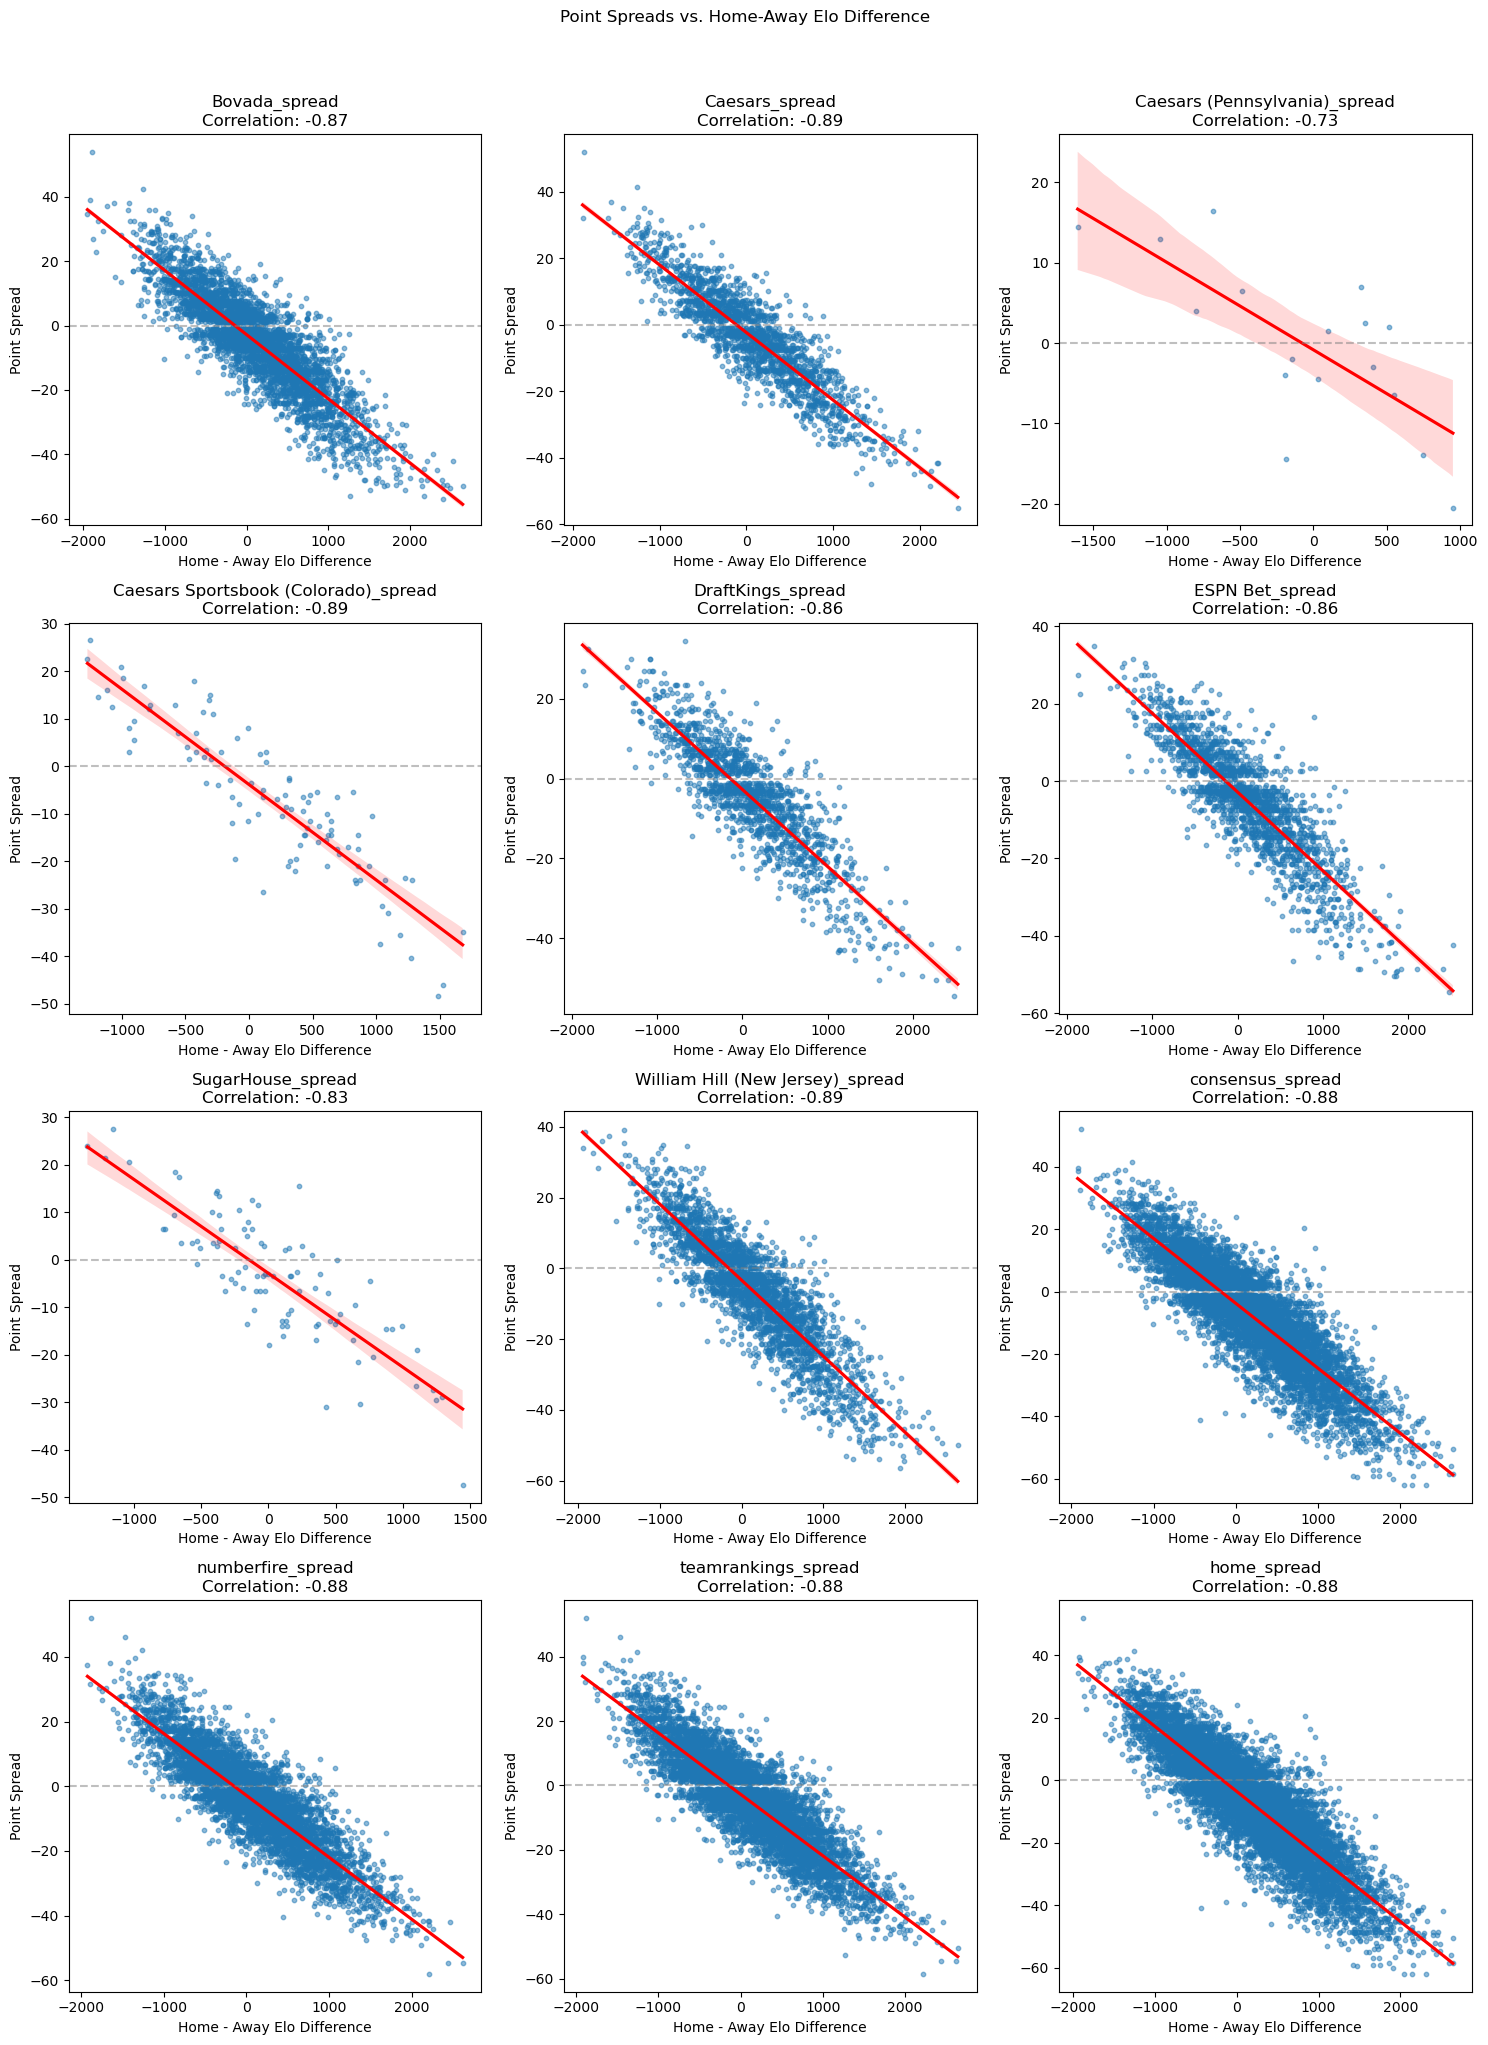

In [11]:
# Verify that all of the point spreads have a negative correlation with the Home - Away Elo difference
# This is a chec to ensure that they are home team point spreads

df_unique = df.drop_duplicates(subset=['game_id'])

df_unique['elo_diff'] = df_unique['home_pregame_elo'] - df_unique['away_pregame_elo']

spread_cols = ['Bovada_spread', 'Caesars_spread', 'Caesars (Pennsylvania)_spread',
               'Caesars Sportsbook (Colorado)_spread', 'DraftKings_spread', 
               'ESPN Bet_spread', 'SugarHouse_spread',
               'William Hill (New Jersey)_spread', 'consensus_spread',
               'numberfire_spread', 'teamrankings_spread', 'home_spread']

plt.figure(figsize=(15, 20))
plt.suptitle('Point Spreads vs. Home-Away Elo Difference', y=1.02)

for i, col in enumerate(spread_cols, 1):
    ax = plt.subplot(4, 3, i)  # 4 rows, 3 columns of subplots
    
    plot_data = df_unique.dropna(subset=[col, 'elo_diff'])
    
    sns.regplot(x='elo_diff', y=col, data=plot_data, 
                scatter_kws={'alpha': 0.5, 's': 10},
                line_kws={'color': 'red'})
    
    corr = plot_data['elo_diff'].corr(plot_data[col])
    
    ax.set_title(f'{col}\nCorrelation: {corr:.2f}')
    ax.set_xlabel('Home - Away Elo Difference')
    ax.set_ylabel('Point Spread')
    
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [12]:
# drop all spread columns except for the home_spread
spread_cols = ['Bovada_spread', 'Caesars_spread', 'Caesars (Pennsylvania)_spread',
               'Caesars Sportsbook (Colorado)_spread', 'DraftKings_spread', 
               'ESPN Bet_spread', 'SugarHouse_spread',
               'William Hill (New Jersey)_spread', 'consensus_spread',
               'numberfire_spread', 'teamrankings_spread']

df = df.drop(columns=spread_cols)

In [13]:
# Filtering
drop_plays = [
    'End of Regulation',
    'End of Game'
]
df = (
    df
    .query('completed == True') # only completed games
    .query('offense_score >= 0 and defense_score >= 0') # no negative scores
    .query('0 <= clock_minutes <= 15 and 0 <= clock_seconds <= 59') # valid clock
    .query('1 <= period <= 4') # valid period, no and overtime
    .query('0 <= yards_to_goal <= 100') # valid yards to goal
    .query('0 <= distance <= 40') # valid distance within reasonable range
    .query('distance <= yards_to_goal') # distance should be less than yards to goal
    .query('~play_text.isin(@drop_plays)') # drop plays with no play text')
    .assign(
        defense_timeouts = np.minimum(np.maximum(df.defense_timeouts, 0), 3),
        offense_timeouts = np.minimum(np.maximum(df.offense_timeouts, 0), 3),
    )
    .reset_index(drop=True)
)

#### Impute the missing home_spread values with a linear regression prediction

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

cols = ['game_id', 'home_spread', 'home_pregame_elo', 'away_pregame_elo']
df_spred_pred = df[cols].query('home_spread.notnull() and home_pregame_elo.notnull() and away_pregame_elo.notnull()').drop_duplicates('game_id')

X = df_spred_pred[['home_pregame_elo', 'away_pregame_elo']]
y = df_spred_pred['home_spread']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')

df['home_spread_pred'] = model.predict(df[['home_pregame_elo', 'away_pregame_elo']])

MAE: 5.633142948730527


In [15]:
df['home_spread'] = df['home_spread'].fillna(df['home_spread_pred'])
df.drop(columns=['home_spread_pred'], inplace=True)

In [16]:
df.head()

,game_id,drive_id,play_id,drive_number,play_number,season,week,season_type,completed,neutral_site,venue_id,home_team,home_id,home_points,away_team,away_id,away_points,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds,home_division,home_pregame_elo,away_division,away_pregame_elo,home_spread
0,332412309,33241230914,332412309113,14,5,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,3.0,2.0,49,51,3,7,8,False,Pass Completion,Colin Reardon pass complete to Chris Humphrey ...,2.370294,7,25,fbs,1954.443118,fcs,1553.191164,2.0
1,332412309,33241230914,332412309115,14,7,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,3.0,2.0,55,45,2,12,0,False,Pass Incompletion,"Colin Reardon pass incomplete to Josh Boyle, b...",-1.031667,7,25,fbs,1954.443118,fcs,1553.191164,2.0
2,332412309,33241230914,332412309112,14,4,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,3.0,2.0,49,51,2,7,0,False,Pass Incompletion,Colin Reardon pass incomplete to Chris Humphrey.,-1.119358,7,25,fbs,1954.443118,fcs,1553.191164,2.0
3,332412309,33241230914,332412309117,14,9,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,2.0,2.0,55,45,3,12,9,False,Pass Completion,Colin Reardon pass complete to Tyshon Goode fo...,0.930991,4,21,fbs,1954.443118,fcs,1553.191164,2.0
4,332412309,33241230914,332412309118,14,10,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,2.0,2.0,64,36,4,3,-3,False,Rush,Colin Reardon rush for a loss of 3 yards to th...,-2.160701,4,21,fbs,1954.443118,fcs,1553.191164,2.0


## 3. Feature Engineering

In [17]:
df = (
    df
    .assign(
        pct_game_played = (((df['period'] - 1) * 15 * 60) + ((15 * 60) - (df['clock_minutes'] * 60 + df['clock_seconds']))) / (4 * 15 * 60),
        game_seconds_remaining = ((4 * 15 * 60) - ((df['period'] - 1) * 15 * 60 + (15 * 60) - (df['clock_minutes'] * 60 + df['clock_seconds']))),
        score_diff = df['offense_score'] - df['defense_score'],
        is_home_team = np.select([df.neutral_site, df.offense == df.home], [0, 1], default=-1),
        pregame_spread = np.where(df['offense'] == df['home'], df['home_spread'], -df['home_spread']),
        pregame_elo_diff = np.where(df['offense'] == df['home'], df['home_pregame_elo'] - df['away_pregame_elo'], df['away_pregame_elo'] - df['home_pregame_elo']),
        pregame_offense_elo = np.where(df['offense'] == df['home'], df['home_pregame_elo'], df['away_pregame_elo']),
        pregame_defense_elo = np.where(df['offense'] == df['home'], df['away_pregame_elo'], df['home_pregame_elo']),
        offense_division = np.where(df['offense'] == df['home'], df['home_division'], df['away_division']),
        defense_division = np.where(df['offense'] == df['home'], df['away_division'], df['home_division']),
        score_diff_final = np.where(df['offense'] == df['home'], df['home_points'] - df['away_points'], df['away_points'] - df['home_points'])
    )

    .assign(
        adjusted_score_diff = lambda x: x['score_diff'] / np.sqrt(1 + x['game_seconds_remaining']),
        diff_time_ratio = lambda x: x['score_diff'] * np.exp(4 * (3600 - x['game_seconds_remaining']) / 3600),
        spread_time_ratio = lambda x: x['pregame_spread'] * np.exp(4 * (3600 - x['game_seconds_remaining']) / 3600),
        log_pct_game_played = lambda x: np.log(1 - x['pct_game_played'] + 1e-6),
    )
)

df.head()

,game_id,drive_id,play_id,drive_number,play_number,season,week,season_type,completed,neutral_site,venue_id,home_team,home_id,home_points,away_team,away_id,away_points,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds,home_division,home_pregame_elo,away_division,away_pregame_elo,home_spread,pct_game_played,game_seconds_remaining,score_diff,is_home_team,pregame_spread,pregame_elo_diff,pregame_offense_elo,pregame_defense_elo,offense_division,defense_division,score_diff_final,adjusted_score_diff,diff_time_ratio,spread_time_ratio,log_pct_game_played
0,332412309,33241230914,332412309113,14,5,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,3.0,2.0,49,51,3,7,8,False,Pass Completion,Colin Reardon pass complete to Chris Humphrey ...,2.370294,7,25,fbs,1954.443118,fcs,1553.191164,2.0,0.626389,1345,-3,1,2.0,401.251954,1954.443118,1553.191164,fbs,fcs,7.0,-0.081771,-36.751088,24.500726,-0.984537
1,332412309,33241230914,332412309115,14,7,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,3.0,2.0,55,45,2,12,0,False,Pass Incompletion,"Colin Reardon pass incomplete to Josh Boyle, b...",-1.031667,7,25,fbs,1954.443118,fcs,1553.191164,2.0,0.626389,1345,-3,1,2.0,401.251954,1954.443118,1553.191164,fbs,fcs,7.0,-0.081771,-36.751088,24.500726,-0.984537
2,332412309,33241230914,332412309112,14,4,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,3.0,2.0,49,51,2,7,0,False,Pass Incompletion,Colin Reardon pass incomplete to Chris Humphrey.,-1.119358,7,25,fbs,1954.443118,fcs,1553.191164,2.0,0.626389,1345,-3,1,2.0,401.251954,1954.443118,1553.191164,fbs,fcs,7.0,-0.081771,-36.751088,24.500726,-0.984537
3,332412309,33241230914,332412309117,14,9,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,2.0,2.0,55,45,3,12,9,False,Pass Completion,Colin Reardon pass complete to Tyshon Goode fo...,0.930991,4,21,fbs,1954.443118,fcs,1553.191164,2.0,0.677500,1161,-3,1,2.0,401.251954,1954.443118,1553.191164,fbs,fcs,7.0,-0.088007,-45.087827,30.058551,-1.131649
4,332412309,33241230914,332412309118,14,10,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,2.0,2.0,64,36,4,3,-3,False,Rush,Colin Reardon rush for a loss of 3 yards to th...,-2.160701,4,21,fbs,1954.443118,fcs,1553.191164,2.0,0.677500,1161,-3,1,2.0,401.251954,1954.443118,1553.191164,fbs,fcs,7.0,-0.088007,-45.087827,30.058551,-1.131649


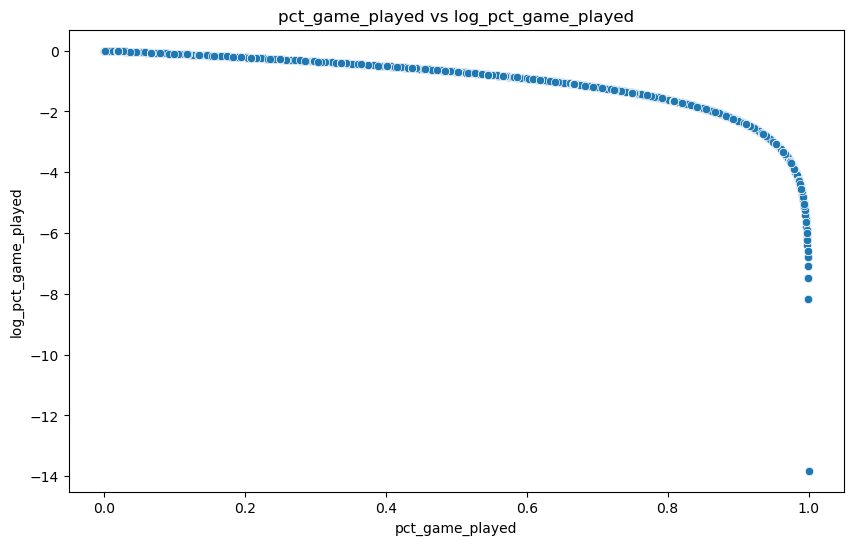

In [18]:
x,y = 'pct_game_played', 'log_pct_game_played'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df.head(100000), x=x, y=y)
plt.title(f'{x} vs {y}')
plt.xlabel(x)
plt.ylabel(y)
plt.show()

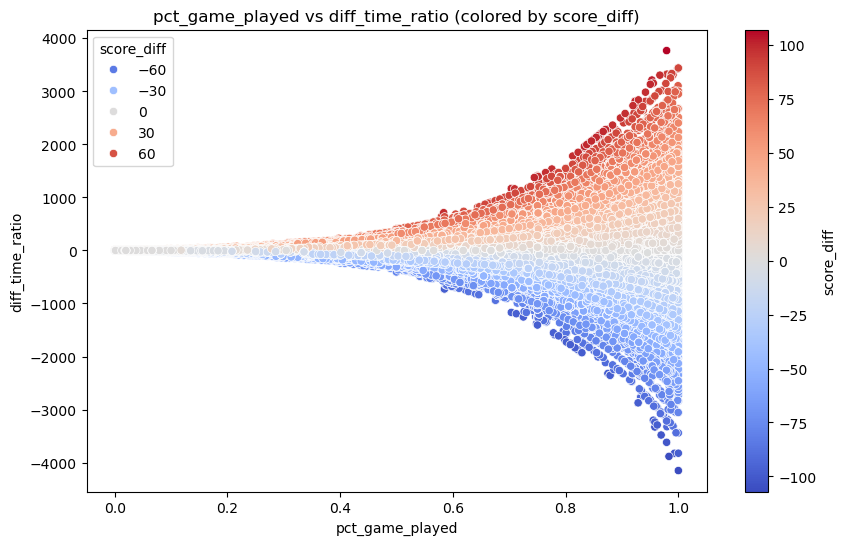

In [19]:
x, y = 'pct_game_played', 'diff_time_ratio'
hue = 'score_diff'

fig, ax = plt.subplots(figsize=(10, 6))  # use subplots to get an Axes object

scatter = sns.scatterplot(data=df.head(100000), x=x, y=y, hue=hue, palette='coolwarm', ax=ax)

# Normalize and create ScalarMappable
norm = mpl.colors.Normalize(vmin=df[hue].min(), vmax=df[hue].max())
sm = mpl.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])

# Add colorbar to the same Axes
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(hue)

# Labels
ax.set_title(f'{x} vs {y} (colored by {hue})')
ax.set_xlabel(x)
ax.set_ylabel(y)

plt.show()

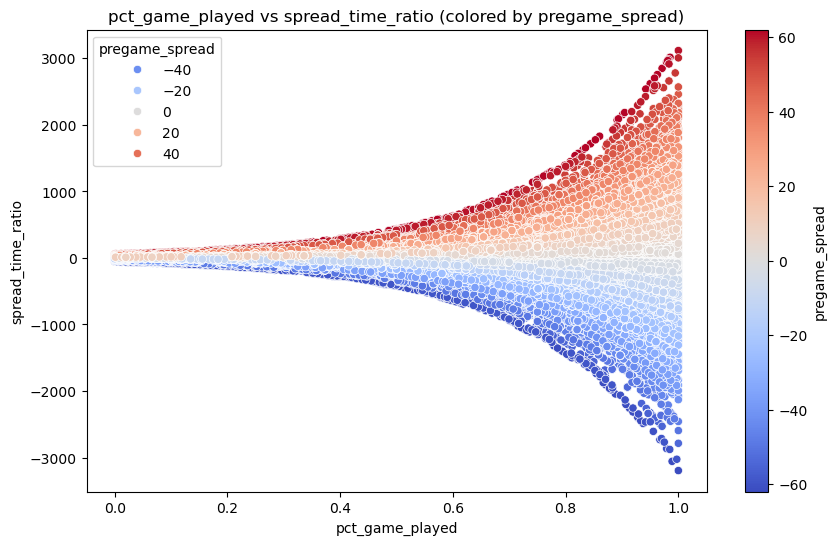

In [20]:
x, y = 'pct_game_played', 'spread_time_ratio'
hue = 'pregame_spread'

fig, ax = plt.subplots(figsize=(10, 6))  # use subplots to get an Axes object

scatter = sns.scatterplot(data=df.head(100000), x=x, y=y, hue=hue, palette='coolwarm', ax=ax)

# Normalize and create ScalarMappable
norm = mpl.colors.Normalize(vmin=df[hue].min(), vmax=df[hue].max())
sm = mpl.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])

# Add colorbar to the same Axes
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(hue)

# Labels
ax.set_title(f'{x} vs {y} (colored by {hue})')
ax.set_xlabel(x)
ax.set_ylabel(y)

plt.show()

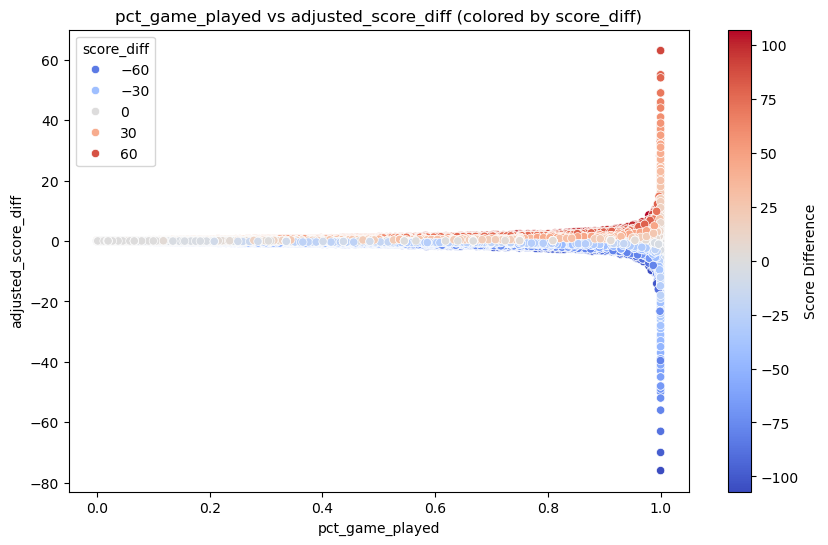

In [21]:
x, y = 'pct_game_played', 'adjusted_score_diff'
fig, ax = plt.subplots(figsize=(10, 6))  # use subplots to get an Axes object

scatter = sns.scatterplot(data=df.head(100000), x=x, y=y, hue='score_diff', palette='coolwarm', ax=ax)

# Normalize and create ScalarMappable
norm = mpl.colors.Normalize(vmin=df['score_diff'].min(), vmax=df['score_diff'].max())
sm = mpl.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])

# Add colorbar to the same Axes
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Score Difference')

# Labels
ax.set_title(f'{x} vs {y} (colored by score_diff)')
ax.set_xlabel(x)
ax.set_ylabel(y)

plt.show()

In [22]:
df.head()

,game_id,drive_id,play_id,drive_number,play_number,season,week,season_type,completed,neutral_site,venue_id,home_team,home_id,home_points,away_team,away_id,away_points,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds,home_division,home_pregame_elo,away_division,away_pregame_elo,home_spread,pct_game_played,game_seconds_remaining,score_diff,is_home_team,pregame_spread,pregame_elo_diff,pregame_offense_elo,pregame_defense_elo,offense_division,defense_division,score_diff_final,adjusted_score_diff,diff_time_ratio,spread_time_ratio,log_pct_game_played
0,332412309,33241230914,332412309113,14,5,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,3.0,2.0,49,51,3,7,8,False,Pass Completion,Colin Reardon pass complete to Chris Humphrey ...,2.370294,7,25,fbs,1954.443118,fcs,1553.191164,2.0,0.626389,1345,-3,1,2.0,401.251954,1954.443118,1553.191164,fbs,fcs,7.0,-0.081771,-36.751088,24.500726,-0.984537
1,332412309,33241230914,332412309115,14,7,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,3.0,2.0,55,45,2,12,0,False,Pass Incompletion,"Colin Reardon pass incomplete to Josh Boyle, b...",-1.031667,7,25,fbs,1954.443118,fcs,1553.191164,2.0,0.626389,1345,-3,1,2.0,401.251954,1954.443118,1553.191164,fbs,fcs,7.0,-0.081771,-36.751088,24.500726,-0.984537
2,332412309,33241230914,332412309112,14,4,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,3.0,2.0,49,51,2,7,0,False,Pass Incompletion,Colin Reardon pass incomplete to Chris Humphrey.,-1.119358,7,25,fbs,1954.443118,fcs,1553.191164,2.0,0.626389,1345,-3,1,2.0,401.251954,1954.443118,1553.191164,fbs,fcs,7.0,-0.081771,-36.751088,24.500726,-0.984537
3,332412309,33241230914,332412309117,14,9,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,2.0,2.0,55,45,3,12,9,False,Pass Completion,Colin Reardon pass complete to Tyshon Goode fo...,0.930991,4,21,fbs,1954.443118,fcs,1553.191164,2.0,0.677500,1161,-3,1,2.0,401.251954,1954.443118,1553.191164,fbs,fcs,7.0,-0.088007,-45.087827,30.058551,-1.131649
4,332412309,33241230914,332412309118,14,10,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Kent State,Liberty,Big South,10,3,2.0,2.0,64,36,4,3,-3,False,Rush,Colin Reardon rush for a loss of 3 yards to th...,-2.160701,4,21,fbs,1954.443118,fcs,1553.191164,2.0,0.677500,1161,-3,1,2.0,401.251954,1954.443118,1553.191164,fbs,fcs,7.0,-0.088007,-45.087827,30.058551,-1.131649


## 4. Final Data

In [23]:
cols = ['game_id', 'drive_id', 'play_id', 'season', 'week', 'season_type', 'venue_id', 
        'offense', 'offense_conference', 'offense_division', 
        'defense', 'defense_conference', 'defense_division', 
        'score_diff', 'pregame_elo_diff', 'pregame_offense_elo', 'pregame_defense_elo', 'pct_game_played',
        'offense_timeouts', 'defense_timeouts', 'is_home_team', 'yards_to_goal',
        'pregame_spread', 'adjusted_score_diff', 'diff_time_ratio',
        'spread_time_ratio', 'log_pct_game_played',
        'score_diff_final']

df = df[cols].query('offense_division == "fbs" or defense_division == "fbs"').reset_index(drop=True)
df.head()

,game_id,drive_id,play_id,season,week,season_type,venue_id,offense,offense_conference,offense_division,defense,defense_conference,defense_division,score_diff,pregame_elo_diff,pregame_offense_elo,pregame_defense_elo,pct_game_played,offense_timeouts,defense_timeouts,is_home_team,yards_to_goal,pregame_spread,adjusted_score_diff,diff_time_ratio,spread_time_ratio,log_pct_game_played,score_diff_final
0,332412309,33241230914,332412309113,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,-3,401.251954,1954.443118,1553.191164,0.626389,3.0,2.0,1,51,2.0,-0.081771,-36.751088,24.500726,-0.984537,7.0
1,332412309,33241230914,332412309115,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,-3,401.251954,1954.443118,1553.191164,0.626389,3.0,2.0,1,45,2.0,-0.081771,-36.751088,24.500726,-0.984537,7.0
2,332412309,33241230914,332412309112,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,-3,401.251954,1954.443118,1553.191164,0.626389,3.0,2.0,1,51,2.0,-0.081771,-36.751088,24.500726,-0.984537,7.0
3,332412309,33241230914,332412309117,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,-3,401.251954,1954.443118,1553.191164,0.677500,2.0,2.0,1,45,2.0,-0.088007,-45.087827,30.058551,-1.131649,7.0
4,332412309,33241230914,332412309118,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,-3,401.251954,1954.443118,1553.191164,0.677500,2.0,2.0,1,36,2.0,-0.088007,-45.087827,30.058551,-1.131649,7.0


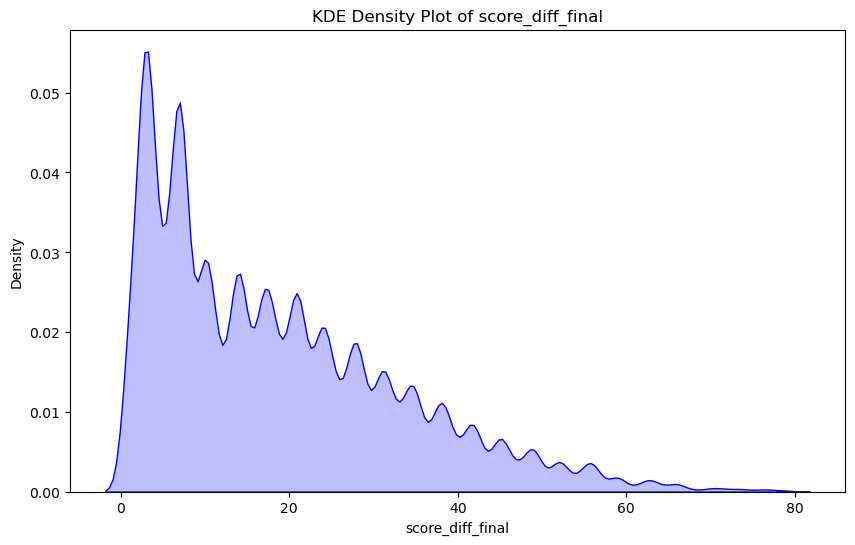

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.kdeplot(df.query('score_diff_final >= 0').score_diff_final, fill=True, color='blue')
plt.title('KDE Density Plot of score_diff_final')
plt.xlabel('score_diff_final')
plt.ylabel('Density')
plt.show()

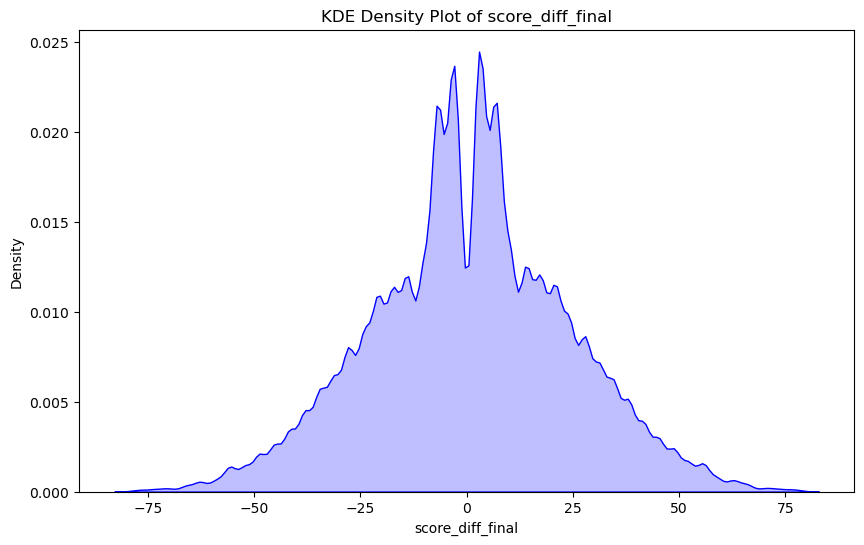

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.kdeplot(df.score_diff_final, fill=True, color='blue')
plt.title('KDE Density Plot of score_diff_final')
plt.xlabel('score_diff_final')
plt.ylabel('Density')
plt.show()

In [26]:
df.head()

,game_id,drive_id,play_id,season,week,season_type,venue_id,offense,offense_conference,offense_division,defense,defense_conference,defense_division,score_diff,pregame_elo_diff,pregame_offense_elo,pregame_defense_elo,pct_game_played,offense_timeouts,defense_timeouts,is_home_team,yards_to_goal,pregame_spread,adjusted_score_diff,diff_time_ratio,spread_time_ratio,log_pct_game_played,score_diff_final
0,332412309,33241230914,332412309113,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,-3,401.251954,1954.443118,1553.191164,0.626389,3.0,2.0,1,51,2.0,-0.081771,-36.751088,24.500726,-0.984537,7.0
1,332412309,33241230914,332412309115,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,-3,401.251954,1954.443118,1553.191164,0.626389,3.0,2.0,1,45,2.0,-0.081771,-36.751088,24.500726,-0.984537,7.0
2,332412309,33241230914,332412309112,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,-3,401.251954,1954.443118,1553.191164,0.626389,3.0,2.0,1,51,2.0,-0.081771,-36.751088,24.500726,-0.984537,7.0
3,332412309,33241230914,332412309117,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,-3,401.251954,1954.443118,1553.191164,0.677500,2.0,2.0,1,45,2.0,-0.088007,-45.087827,30.058551,-1.131649,7.0
4,332412309,33241230914,332412309118,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,-3,401.251954,1954.443118,1553.191164,0.677500,2.0,2.0,1,36,2.0,-0.088007,-45.087827,30.058551,-1.131649,7.0


In [27]:
df['won'] = np.where(df['score_diff_final'] > 0, 1, 0)

In [28]:
df.columns

Index(['game_id', 'drive_id', 'play_id', 'season', 'week', 'season_type',
       'venue_id', 'offense', 'offense_conference', 'offense_division',
       'defense', 'defense_conference', 'defense_division', 'score_diff',
       'pregame_elo_diff', 'pregame_offense_elo', 'pregame_defense_elo',
       'pct_game_played', 'offense_timeouts', 'defense_timeouts',
       'is_home_team', 'yards_to_goal', 'pregame_spread',
       'adjusted_score_diff', 'diff_time_ratio', 'spread_time_ratio',
       'log_pct_game_played', 'score_diff_final', 'won'],
      dtype='object')

## 5. Make the model

In [ ]:
additional_features = [
    'pregame_spread',
    'adjusted_score_diff',
    'diff_time_ratio',
    'spread_time_ratio',
    'log_pct_game_played',
    'score_diff_final'
]

data = df[['game_id','drive_id','score_diff','pregame_elo_diff','pct_game_played','is_home_team',
           'offense_timeouts','defense_timeouts','yards_to_goal',
           'won'] + additional_features].copy()


SEED = 2

# Split into 80-20 train val set by game_id
game_ids = df.game_id.unique()
game_ids_train, game_ids_test = train_test_split(game_ids, test_size=0.2, random_state=SEED)

data_train = data[data.game_id.isin(game_ids_train)]
data_test = data[data.game_id.isin(game_ids_test)].drop(columns=['drive_id'])
game_ids_train, game_ids_valid = train_test_split(
    data_train.game_id.unique(), 
    test_size=0.2, 
    random_state=SEED
)
train = data_train[data_train.game_id.isin(game_ids_train)]
valid = data_train[data_train.game_id.isin(game_ids_valid)]

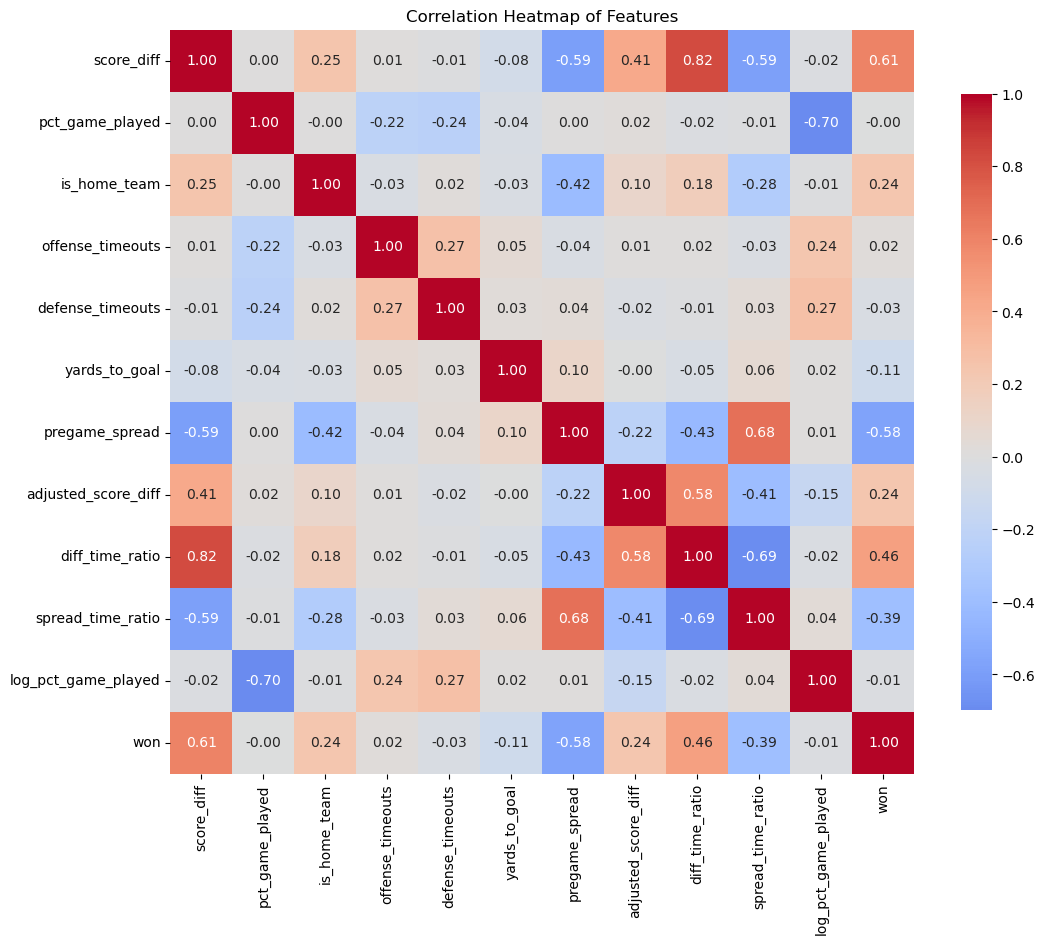

In [71]:
base_features = [
    'score_diff',
    # 'pregame_elo_diff',
    'pct_game_played',
    'is_home_team',
    'offense_timeouts',
    'defense_timeouts',
    'yards_to_goal'
]
additional_features = [
    'pregame_spread',
    'adjusted_score_diff',
    'diff_time_ratio',
    'spread_time_ratio',
    'log_pct_game_played',
]

feature_set = base_features + additional_features + ['won']

# correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    data[feature_set].corr(), 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    center=0,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Heatmap of Features')
plt.show()

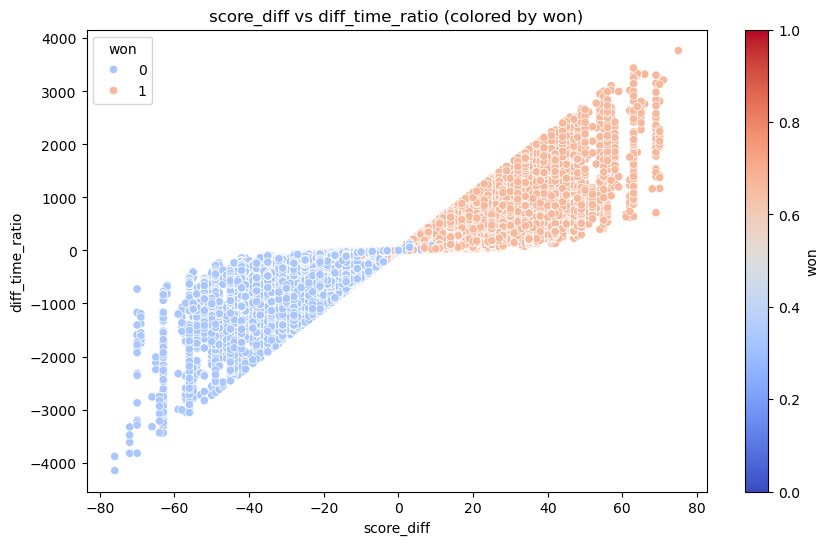

In [78]:
x, y = 'score_diff', 'diff_time_ratio'
hue = 'won'

fig, ax = plt.subplots(figsize=(10, 6))  # use subplots to get an Axes object

scatter = sns.scatterplot(data=df.head(100000), x=x, y=y, hue=hue, palette='coolwarm', ax=ax)

# Normalize and create ScalarMappable
norm = mpl.colors.Normalize(vmin=df[hue].min(), vmax=df[hue].max())
sm = mpl.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])

# Add colorbar to the same Axes
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(hue)

# Labels
ax.set_title(f'{x} vs {y} (colored by {hue})')
ax.set_xlabel(x)
ax.set_ylabel(y)

plt.show()

In [156]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from tqdm import tqdm

optuna.logging.set_verbosity(optuna.logging.CRITICAL)
SEED = 2
np.random.seed(SEED)

feature_names = [
    'diff_time_ratio',
    'score_diff',
    'spread_time_ratio',
    'pregame_spread',
    'is_home_team',
    'offense_timeouts',
    'defense_timeouts',
    'yards_to_goal'
]

# Prepare features and monotonic constraints
monotonic_constraints_map = {
    "score_diff": 1,
    "pregame_elo_diff": 1,
    "is_home_team": 1,
    "yards_to_goal": -1,
    "pregame_spread": -1,
    "diff_time_ratio": 1,
    "spread_time_ratio": -1,
}
monotonic_constraints = tuple([monotonic_constraints_map.get(feature, 0) for feature in feature_names])

# Objective function for Optuna
def objective(trial, dtrain, dvalid):
    param = {
        "nthread": -1,
        "objective": "binary:logistic",
        "monotone_constraints": monotonic_constraints,
        "eval_metric": "logloss",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight": trial.suggest_float("min_child_weight", .5, 10, step=.5),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }
    
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False
    )
    preds = bst.predict(dvalid)
  
    return log_loss(valid_y, preds)


train_x = train[feature_names]
train_y = train['won']
valid_x = valid[feature_names]
valid_y = valid['won']

# Create DMatrix objects
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

# Run Optuna optimization
study = optuna.create_study(
    study_name="win_probability_hyperopt", 
    direction="minimize", 
    load_if_exists=True
)
study.optimize(lambda trial: objective(trial, dtrain, dvalid), n_trials=50)

# Train final model with best parameters
best_params = {
    **study.best_trial.params,
    'nthread': -1,
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'monotone_constraints': monotonic_constraints,
    'eval_metric': 'logloss',
    'seed': SEED,
}

final_model = xgb.train(
    best_params, 
    dtrain,
    num_boost_round=500,
    evals=[(dvalid, "eval")],
    early_stopping_rounds=10,
    verbose_eval=False
)

# Evaluate on train set
train_preds = final_model.predict(dtrain)
print(f"Final train log loss: {log_loss(train_y, train_preds):0.3f}")

# Evaluate on validation set
valid_preds = final_model.predict(dvalid)
print(f"Final validation log loss: {log_loss(valid_y, valid_preds):0.3f}")

# Evaluate on test set
dtest = xgb.DMatrix(data_test[feature_names], label=data_test['won'])
test_preds = final_model.predict(dtest)
print(f"Final test log loss: {log_loss(data_test['won'], test_preds):0.3f}")

Final train log loss: 0.343
Final validation log loss: 0.335
Final test log loss: 0.329


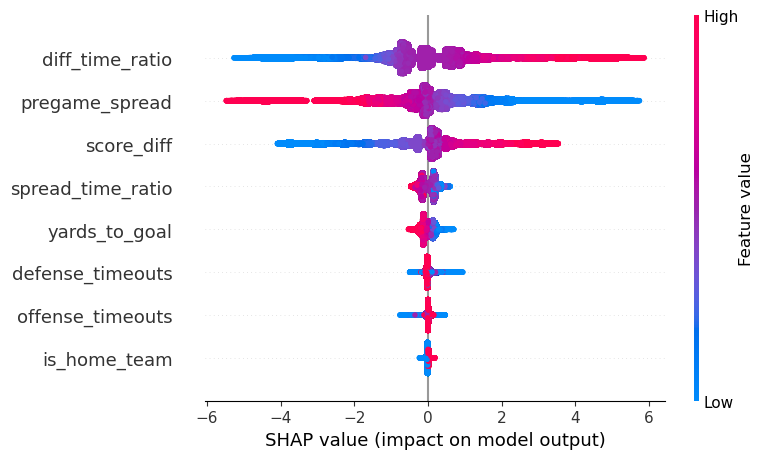

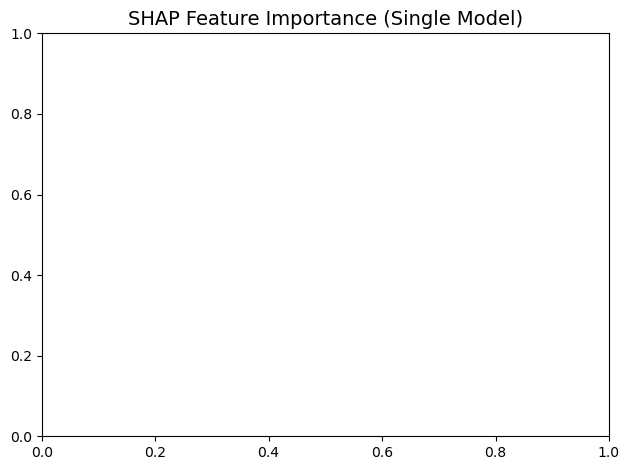

In [157]:
import shap
background = train[feature_names]
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(background)
shap.summary_plot(shap_values, 
                 background, 
                 plot_type="dot",  # "dot" (default), "bar", or "violin"
                 max_display=15,
                 show=True)

plt.title("SHAP Feature Importance (Single Model)", fontsize=14)
plt.tight_layout()
plt.show()

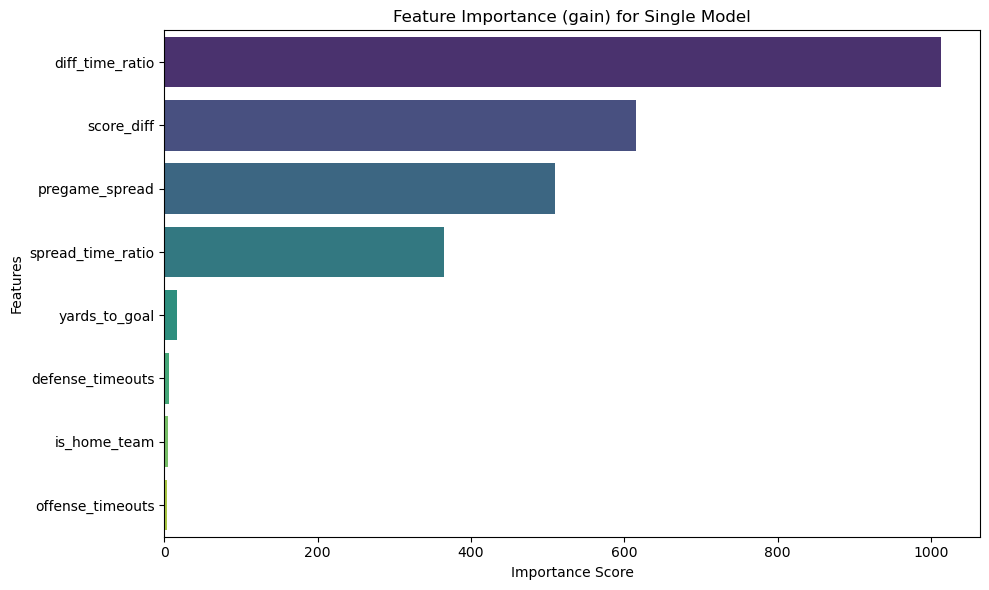

In [158]:
importance_type = "gain"  # Options: "gain", "weight", "cover"

# Get feature importance for a single model
importance = final_model.get_score(importance_type=importance_type)

# Convert to DataFrame and sort
importance_df = pd.DataFrame({
    "Feature": list(importance.keys()),
    "Importance": list(importance.values())
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance", 
    y="Feature", 
    data=importance_df, 
    palette="viridis", 
    hue="Feature", 
    dodge=False
)
plt.title(f"Feature Importance ({importance_type}) for Single Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()

In [159]:
# predict win_proba for all plays
df['win_proba'] = final_model.predict(xgb.DMatrix(df[feature_names]))

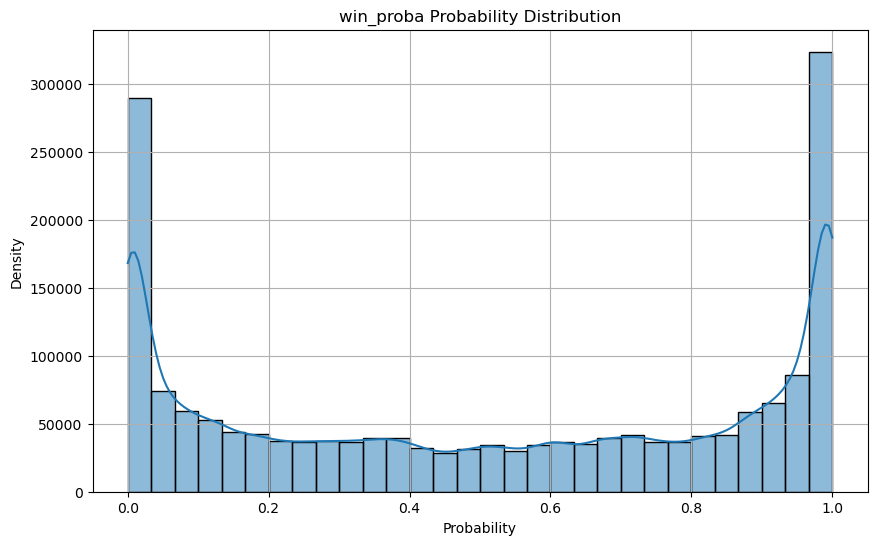

In [160]:
# plot win probability
def plot_wp(df, col):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'{col} Probability Distribution')
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.grid()
    plt.show()
plot_wp(df, col='win_proba')

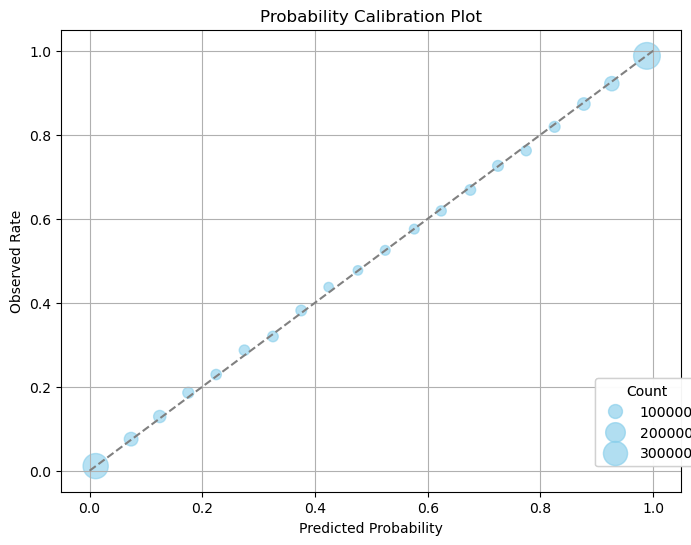

In [161]:
calibration = pd.DataFrame()
def plot_calibration(df, proba_col, actual_col, bins=100, scale=0.2):
    global calibration
    df['proba_bin'] = pd.cut(df[proba_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('proba_bin').agg(
        predicted_proba=(proba_col, 'mean'),
        actual_proba=(actual_col, 'mean'),
        count=(proba_col, 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        calibration['predicted_proba'], 
        calibration['actual_proba'], 
        s=calibration['count'] * scale,
        alpha=0.6, 
        label='Calibration Curve',
        color='skyblue',
    )
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Rate')
    plt.title('Probability Calibration Plot')
    plt.grid()

    # Add legend for dot size reference
    handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6, num=4, func=lambda x: x / scale,
                                              color='skyblue')
    labels = [int(re.search(r'\{(\d+)\}', value).group(1)) for value in labels]
    legend = plt.legend(handles, labels, title="Count", loc="center left", bbox_to_anchor=(.85, 0.15))
    plt.gca().add_artist(legend)

    plt.show()

plot_calibration(df, proba_col='win_proba', actual_col='won', bins=20, scale=0.001)

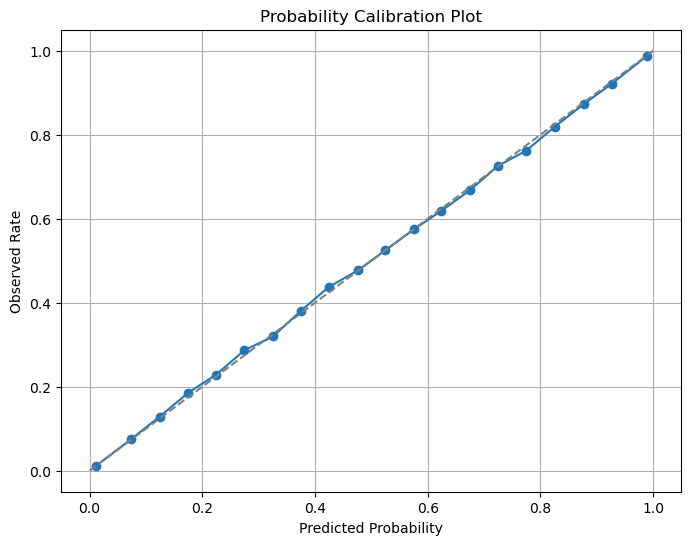

In [162]:
calibration = pd.DataFrame()
def plot_calibration(df, proba_col, actual_col, bins=100, scale=0.2):
    global calibration
    df['proba_bin'] = pd.cut(df[proba_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('proba_bin').agg(
        predicted_proba=(proba_col, 'mean'),
        actual_proba=(actual_col, 'mean'),
        count=(proba_col, 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    plt.plot(calibration['predicted_proba'], calibration['actual_proba'], label='Calibration Curve', marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Rate')
    plt.title('Probability Calibration Plot')
    plt.grid()
    plt.show()

plot_calibration(df, proba_col='win_proba', actual_col='won', bins=20)

In [163]:
gid = 401112489
teams = df_plays.query('game_id == @gid').offense.unique()

(
    df_plays.query('game_id == @gid')
    .query('offense == @teams[0]')
    .sort_values(['drive_number', 'play_number'])
    .drop_duplicates('drive_id', keep='last')
    [['period', 'clock_minutes', 'offense', 'offense_score', 'defense', 'defense_score']]
)

,period,clock_minutes,offense,offense_score,defense,defense_score
1050464,1,15,Virginia Tech,0,North Carolina,0
1050389,1,14,Virginia Tech,0,North Carolina,7
1050463,1,10,Virginia Tech,0,North Carolina,10
1050430,1,0,Virginia Tech,7,North Carolina,10
1050435,1,0,Virginia Tech,7,North Carolina,10
1050456,2,11,Virginia Tech,7,North Carolina,10
1050477,2,3,Virginia Tech,14,North Carolina,17
1050417,2,3,Virginia Tech,14,North Carolina,17
1050394,2,0,Virginia Tech,21,North Carolina,17
1050416,2,0,Virginia Tech,21,North Carolina,17


In [164]:
df.query('game_id == @gid')[['offense', 'pregame_spread']].head(1)

,offense,pregame_spread
1011835,Virginia Tech,4.5


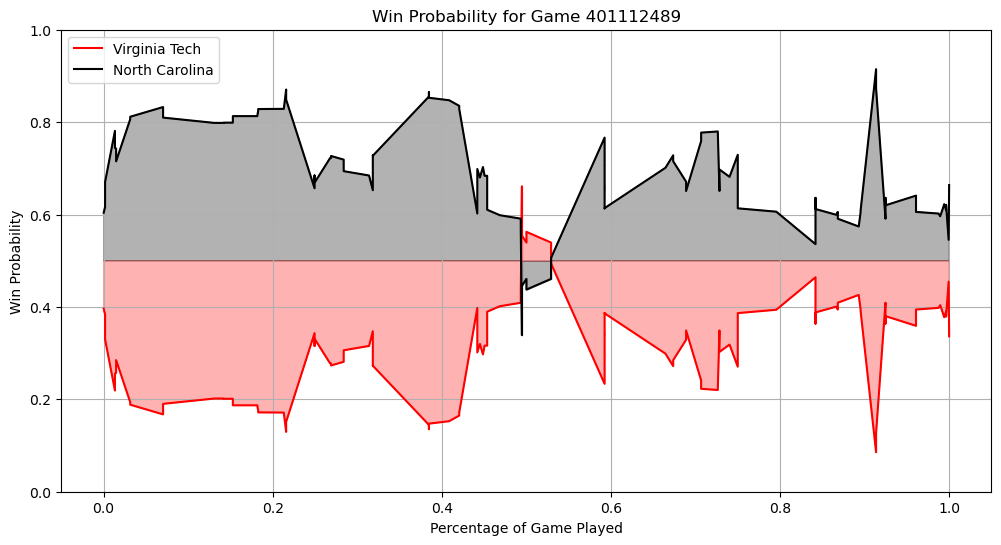

In [165]:
def plot_wp_game(df, game_id, wp_col):
    cols = ['game_id', 'drive_id', 'play_id', 'pct_game_played', 'offense', wp_col, 'score_diff']
    game = (
        df.query('game_id == @game_id')
        .sort_values(['pct_game_played','play_id'], ascending=[True, True])
        [cols]
    )
    teams = game.offense.unique()
    t1, t2 = game.copy(), game.copy()
    t1[wp_col] = np.where(t1['offense'] == teams[0], t1[wp_col], 1 - t1[wp_col])
    t2[wp_col] = np.where(t2['offense'] == teams[1], t2[wp_col], 1 - t2[wp_col])

    plt.figure(figsize=(12, 6))
    plt.plot(t1['pct_game_played'], t1[wp_col], label=teams[0], color='red')
    plt.fill_between(t1['pct_game_played'], t1[wp_col], 0.5, where=(t1[wp_col] >= 0.5), color='red', alpha=0.3)
    plt.fill_between(t1['pct_game_played'], t1[wp_col], 0.5, where=(t1[wp_col] < 0.5), color='red', alpha=0.3)

    plt.plot(t2['pct_game_played'], t2[wp_col], label=teams[1], color='black')
    plt.fill_between(t2['pct_game_played'], t2[wp_col], 0.5, where=(t2[wp_col] >= 0.5), color='black', alpha=0.3)
    plt.fill_between(t2['pct_game_played'], t2[wp_col], 0.5, where=(t2[wp_col] < 0.5), color='black', alpha=0.3)

    plt.title(f'Win Probability for Game {game_id}')
    plt.xlabel('Percentage of Game Played')
    plt.ylabel('Win Probability')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid()

plot_wp_game(df, gid, wp_col='win_proba')

In [166]:
df.head()

,game_id,drive_id,play_id,season,week,season_type,venue_id,offense,offense_conference,offense_division,defense,defense_conference,defense_division,score_diff,pregame_elo_diff,pregame_offense_elo,pregame_defense_elo,pct_game_played,offense_timeouts,defense_timeouts,is_home_team,yards_to_goal,pregame_spread,adjusted_score_diff,diff_time_ratio,spread_time_ratio,log_pct_game_played,score_diff_final,won,win_proba,proba_bin,wp_rolling
1670,332410006,33241000601,332410006002,2013,1,regular,3797.0,South Alabama,Sun Belt,fbs,Southern Utah,Big Sky,fcs,0,-431.656511,1047.016602,1478.673114,0.0,3.0,3.0,0,75,-41.0,0.0,0.0,-41.0,9.999995e-07,-1.0,0,0.995289,19,NaN
1669,332410006,33241000601,332410006003,2013,1,regular,3797.0,South Alabama,Sun Belt,fbs,Southern Utah,Big Sky,fcs,0,-431.656511,1047.016602,1478.673114,0.0,3.0,3.0,0,69,-41.0,0.0,0.0,-41.0,9.999995e-07,-1.0,0,0.995289,19,NaN
1671,332410006,33241000601,332410006004,2013,1,regular,3797.0,South Alabama,Sun Belt,fbs,Southern Utah,Big Sky,fcs,0,-431.656511,1047.016602,1478.673114,0.0,3.0,3.0,0,64,-41.0,0.0,0.0,-41.0,9.999995e-07,-1.0,0,0.995289,19,0.997656
1672,332410006,33241000601,332410006005,2013,1,regular,3797.0,South Alabama,Sun Belt,fbs,Southern Utah,Big Sky,fcs,0,-431.656511,1047.016602,1478.673114,0.0,3.0,3.0,0,52,-41.0,0.0,0.0,-41.0,9.999995e-07,-1.0,0,0.995736,19,0.997656
1675,332410006,33241000601,332410006006,2013,1,regular,3797.0,South Alabama,Sun Belt,fbs,Southern Utah,Big Sky,fcs,0,-431.656511,1047.016602,1478.673114,0.0,3.0,3.0,0,53,-41.0,0.0,0.0,-41.0,9.999995e-07,-1.0,0,0.995736,19,0.997656


In [167]:
model_dir = join(DATA_DIR, 'models', 'win_probability')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, f"model.json")

print(f"Saved model to the '{model_dir}' folder.")

Saved model to the '../data/models/win_probability' folder.
